# Annual Race Review

In [186]:
import pandas as pd
import numpy as np
import datetime
import os


# Viz libs
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px

# display options
# pd.options.display.float_format = "{:.2f}".format


import set_config


In [187]:
dir_local = set_config.ConfigSectionMap("SectionOne")['local']
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_race = set_config.ConfigSectionMap("SectionOne")['race']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))
print ("dir_race is %s" % (dir_race))

dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/
dir_race is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Race Dashboard data


In [188]:
folder = 'Race Dashboard data'

file = ('df_weekly_with_calcs.xlsx')

path = os.path.join(dir_race, file)
                    
df = pd.read_excel(path)

df[['OEE %','Changeover','Unplanned_tech_loss','Changeover_rolling_mean', 'OEE_Diff','Changeover_Diff']] = df[['OEE %','Changeover','Unplanned_tech_loss','Changeover_rolling_mean','OEE_Diff','Changeover_Diff']].mul(100)


In [189]:
folder = 'OEE data'


file = ('Duration_of_Changeover.xlsx')

path = os.path.join(dir_sanofi_share, folder, file)
                    
df_duration = pd.read_excel(path,  parse_dates=['Calendar Day'])

file = ('No_of_changeovers.xlsx')
path = os.path.join(dir_sanofi_share, folder, file)

df_changeover_count = pd.read_excel(path)

# df[['OEE %','Changeover','Unplanned_tech_loss','Changeover_rolling_mean', 'OEE_Diff','Changeover_Diff']] = df[['OEE %','Changeover','Unplanned_tech_loss','Changeover_rolling_mean','OEE_Diff','Changeover_Diff']].mul(100)


In [190]:
df_changeover_count['WeekOfYear'] = pd.to_numeric(df_changeover_count['Week'].str[1:3])
df_changeover_count['Year'] = pd.to_numeric(df_changeover_count['Week'].str[4:])
dates = df_changeover_count.Year*100+df_changeover_count.WeekOfYear
df_changeover_count['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
df_changeover_count.head()

,Week,Line,No of Changeovers,WeekOfYear,Year,Date
0,W01-2020,LSX - 1030 Packaging Line,2,1,2020,2020-01-12
1,W01-2020,LSX - 1070-1 Packaging Line,1,1,2020,2020-01-12
2,W01-2020,LSX - 1070-2 Packaging Line,0,1,2020,2020-01-12
3,W01-2020,LSX - C65-1 Packaging Line,0,1,2020,2020-01-12
4,W01-2020,LSX - C65-2 Packaging Line,0,1,2020,2020-01-12


In [191]:
# time data '2021-10-17 00:00:00' does not match format '%d.%m.%Y %H:%M:%S' (match)
# pd.to_timedelta(df_dates.Duration[df_dates['Message Text (English)'].str.contains('1462-7B1')], unit='s')

df_duration['Duration (min)'] = pd.to_datetime(df_duration['Duration (min)'], format='%H:%M:%S', errors='coerce')

In [192]:
df_duration[df_duration['Duration (min)'].isna()]

,Line,Calendar Day,Duration (min)
219,"FRA - Devices AI, Semi 120-1 Assembly",2021-04-02,NaT
220,"FRA - Devices AI, Semi 120-1 Assembly",2021-04-03,NaT
1843,"FRA - FF NAPA, M46 Filling",2021-06-16,NaT
1869,"FRA - FF NAPA, M46 Filling",2021-07-28,NaT
1902,"FRA - FF NAPA, M46 Filling",2021-09-25,NaT
...,...,...,...
19063,SUZ - FETTE 3090 I,2021-11-07,NaT
19064,SUZ - FETTE 3090 I,2021-11-08,NaT
19080,SUZ - FETTE 3090 III,2021-11-13,NaT
19081,SUZ - FETTE 3090 III,2021-11-14,NaT


In [193]:
df_duration['time'] = df_duration['Duration (min)'] - pd.to_datetime('1900-01-01 00:00:00')
df_duration.sort_values('time', ascending=False)
df_duration_grouped = df_duration.set_index('Calendar Day').groupby(['Line', pd.Grouper(freq='W')]).sum().reset_index()
df = df.merge(df_duration_grouped[['Line','time', 'Calendar Day']], left_on=['Line', 'Date'], right_on=['Line','Calendar Day'])
df = df.merge(df_changeover_count[['Line','Date','No of Changeovers']], on=['Line', 'Date'])

In [194]:
# if time is greater than 0 there should be at least 1 changeover
df.loc[(df['time']>pd.to_timedelta(0)) & (df['No of Changeovers'] == 0), 'No of Changeovers'] = 1

Text(0, 0.5, 'Changeover')

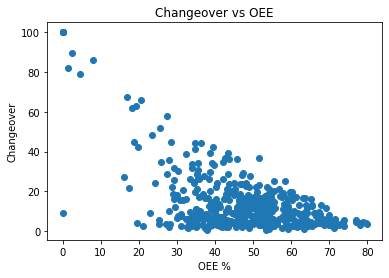

In [195]:
x = df['OEE %']
y = df['Changeover']

plt.scatter(x, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Changeover vs OEE')
plt.xlabel('OEE %')
plt.ylabel('Changeover')

Text(0, 0.5, 'Changeover')

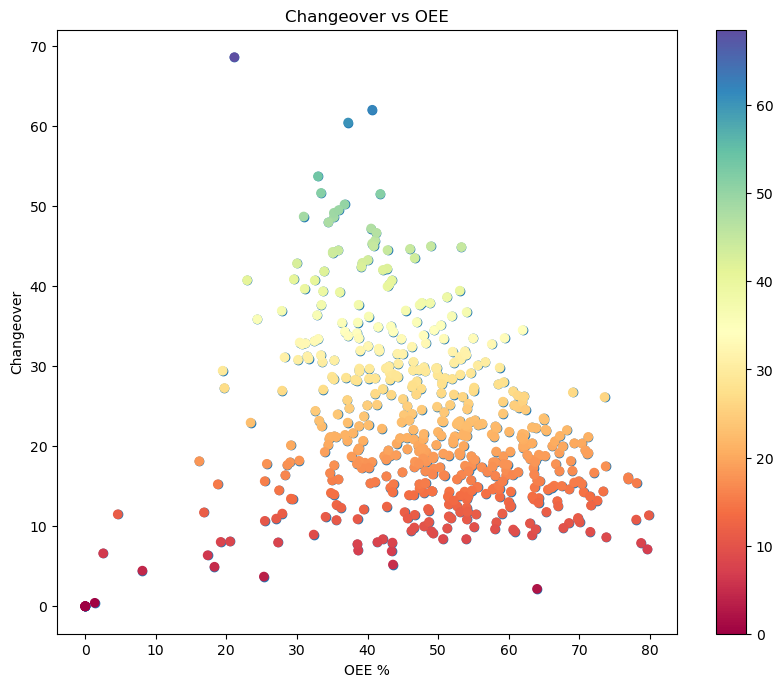

In [196]:
x = df['OEE %']
y = df['Unplanned_tech_loss']
colors = df['Line']

plt.scatter(x, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Changeover vs OEE')
plt.scatter(x, y, c=y, cmap='Spectral')
plt.colorbar()
plt.xlabel('OEE %')
plt.ylabel('Changeover')

<AxesSubplot:title={'center':'Changeover SFI'}, xlabel='Date'>

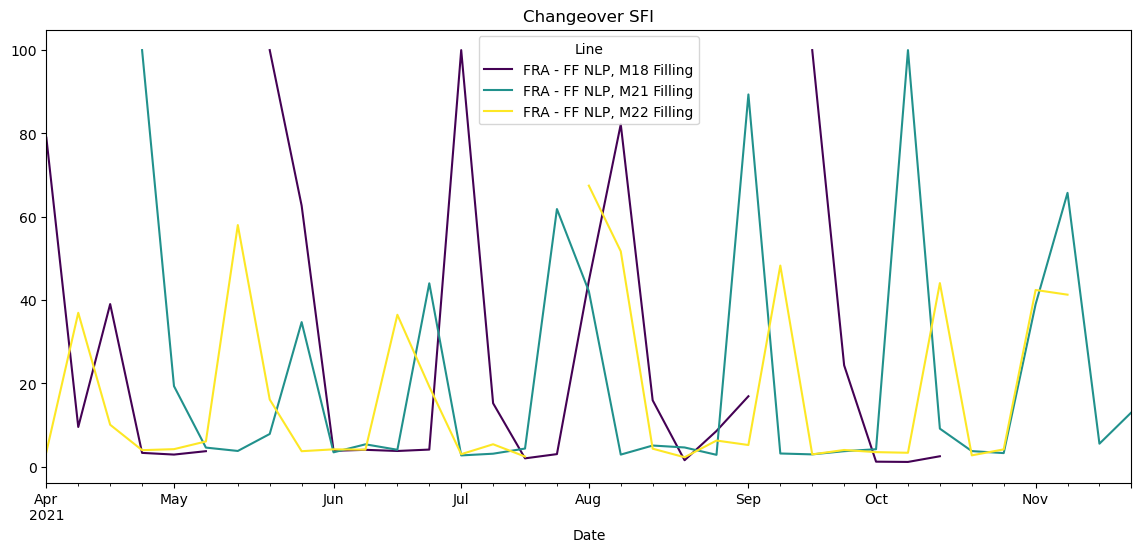

In [197]:
df.pivot_table(index='Date', columns='Line', values='Changeover').filter(regex='M18|M21|M22').plot(figsize=(14,6), title='Changeover SFI', cmap='viridis')

# sns.lineplot(data=df, x='Date', y='Changeover')

In [198]:
pivot_cols = df.pivot_table(index='Date', columns='Line', values='Changeover_rolling_mean').columns
packaging = pivot_cols[~pivot_cols.str.contains('M18|M21|M22')]
filling = pivot_cols[pivot_cols.str.contains('M18|M21|M22')]

In [199]:
px.line(df[df.Line.isin(packaging)], x='Date', y='Changeover_rolling_mean', 
    title='Changeover rolling mean for PACKAGING lines',
    color='Line',
    range_y=(0,40)
    )

In [200]:
px.line(df[df.Line.isin(filling)], x='Date', y='Changeover_rolling_mean', 
    title='Changeover rolling mean for FILLING lines',
    color='Line',
    range_y=(0,100))

In [201]:
# import plotly.graph_objects as go # or plotly.express as px
# # fig = px.lineplot(data=df, x=df['Date'], y=df['Changeover_rolling_mean'], hue='Line')
# fig = px.line(df, x='Date', y='Changeover_rolling_mean', color='Line')
# # fig = go.Figure() # or any Plotly Express function e.g. px.bar(...)


# import dash
# from dash import dcc
# import dash_html_components as html

# app = dash.Dash()
# app.layout = html.Div([
#     dcc.Graph(figure=fig)
# ])

# app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

In [202]:
df.sort_values(['Line','Date'], inplace=True)
df[df.Line == 'FRA - FF NLP, M18 Filling'][['Changeover','Changeover_rolling_mean']]

,Changeover,Changeover_rolling_mean
0,78.978102,78.978102
14,9.540429,44.259265
25,39.041677,42.520069
40,3.324100,32.721077
44,2.918981,13.706297
57,3.733135,12.254473
91,100.000000,26.663029
105,62.659033,41.598042
123,3.818452,41.619371
133,4.059761,42.634312


In [203]:
fig = px.line(df, x='Date', y='Changeover_rolling_mean', 
              color='Line', width=800, height=500,
             title='Rolling Average of Changeover')
fig.show()
file = 'line.html'
path = os.path.join(dir_local, file)
fig.write_html(path)

In [204]:
px.bar(df.groupby('Line').Changeover_rolling_mean.mean().sort_values(ascending=False), 
       orientation='h',
      title='Average Changeover_rolling_mean')

In [205]:
px.bar(df.groupby('Line').Changeover.sum().sort_values(ascending=False), 
       orientation='h',
      title='Using sum of Changeover')

In [206]:
# recalc the diff in case of missing lines of data
df.sort_values(by=['Line','Date'])
# fillna with 0 - otherwise the unplanned_diff calc won't add up.
df['Changeover_Diff'] = df.groupby(['Line'])['Changeover'].diff().fillna(0)

In [207]:
fig = px.bar(round(df.groupby('Line').Changeover_Diff.sum().sort_values(ascending=False),0), x='Changeover_Diff', 
       orientation='h',
      title='Difference in Changeover',
      labels={'Changeover_Diff': 'Point of OEE'},
      text='Changeover_Diff')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')   
# fig.update.xaxis.tickfont = dict(color = 'rgba(0,0,0,0)')


In [208]:
fig = px.bar(df.groupby('Line').Unplanned_tech_loss.sum().sort_values(), x='Unplanned_tech_loss', 
       orientation='h',
      title='Unplanned_tech_loss',
      text='Unplanned_tech_loss')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')   

fig.show()

In [209]:
# now calculate the avg changeover
df['avg_changeover_time'] = df['time'] / df['No of Changeovers']

In [211]:
fig = px.line(df[df.Line.isin(packaging)], x='Date', y='avg_changeover_time', 
              color='Line', width=1000, height=600,
             title='avg time in changeover')
fig.show()
# file = 'line.html'
# path = os.path.join(dir_local, file)
# fig.write_html(path)

In [212]:
fig = px.scatter(df, x='Date', y='No of Changeovers', width=1000, height=600,
             color='Line', title='No of Changeovers', trendline='ols')
fig.show()

In [213]:
fig = px.scatter(df, x='OEE %', y='time', width=800, height=500,
             color='Line', title='time in changeover')
fig.show()

In [214]:
df.sort_values(by=['Line','Date'])
# fillna with 0 - otherwise the unplanned_diff calc won't add up.
df['Unplanned_diff'] = df.groupby(['Line'])['Unplanned_tech_loss'].diff().fillna(0)

In [215]:
df[['Line','Date','Unplanned_tech_loss','Unplanned_diff']][df.Line.str.contains('GAMMA')].sum()

Line                   SCO - GAMMA1SCO - GAMMA1SCO - GAMMA1SCO - GAMM...
Unplanned_tech_loss                                           561.988128
Unplanned_diff                                                -14.821217
dtype: object

In [216]:
fig = px.bar(round(df.groupby(['Line'])['Unplanned_diff'].sum().sort_values(ascending=False), 0), x='Unplanned_diff', 
    orientation='h',
    title='Difference in unplanned_tech_loss',
    labels={"Unplanned_diff": "Point of OEE%"},
    text='Unplanned_diff'
    )
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')   


In [217]:
px.line(df, x='Date', y='Unplanned_tech_loss',
    title='Unplanned_tech_loss',
    color='Line',
    labels={"Unplanned_tech_loss": "Point of OEE%"}
    )

In [218]:
df[['Line','Unplanned_tech_loss','Date','Unplanned_diff']][df.Line.str.contains('GAMMA')]

,Line,Unplanned_tech_loss,Date,Unplanned_diff
5,SCO - GAMMA1,29.138889,2021-04-04,0.000000
18,SCO - GAMMA1,31.927594,2021-04-11,2.788705
29,SCO - GAMMA1,13.883738,2021-04-18,-18.043856
41,SCO - GAMMA1,20.066918,2021-04-25,6.183180
52,SCO - GAMMA1,17.987383,2021-05-02,-2.079535
65,SCO - GAMMA1,16.392766,2021-05-09,-1.594617
77,SCO - GAMMA1,19.691400,2021-05-16,3.298635
82,SCO - GAMMA1,19.332479,2021-05-23,-0.358922
106,SCO - GAMMA1,17.926705,2021-05-30,-1.405774
116,SCO - GAMMA1,18.054563,2021-06-06,0.127859


In [219]:
df.sort_values(['Line','Date'], inplace=True)
df['OEE_Diff_2'] = df.groupby(['Line'])['OEE %'].diff()

In [220]:
fig = px.bar(df.groupby(['Line']).OEE_Diff_2.sum().sort_values(ascending=False), x='OEE_Diff_2', orientation='h',
    labels={'OEE_Diff_2': 'Point of OEE'},
    width=1000, height=600,
    text='OEE_Diff_2',
    title='Difference in OEE')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

In [221]:
px.line(df, x='Date', y='OEE %',
    title='OEE %',
    color='Line',
    width=1000, height=600,
    labels={"OEE %": "Point of OEE%"}
    )

In [222]:
df[['Line','OEE %','Date','OEE_Diff','OEE_Diff_2']][df.Line.str.contains('M22')]

,Line,OEE %,Date,OEE_Diff,OEE_Diff_2
9,"FRA - FF NLP, M22 Filling",64.933565,2021-04-04,11.926774,NaN
11,"FRA - FF NLP, M22 Filling",42.731634,2021-04-11,-22.201930,-22.201930
31,"FRA - FF NLP, M22 Filling",52.051124,2021-04-18,9.319490,9.319490
37,"FRA - FF NLP, M22 Filling",70.370271,2021-04-25,18.319147,18.319147
49,"FRA - FF NLP, M22 Filling",70.846346,2021-05-02,0.476075,0.476075
56,"FRA - FF NLP, M22 Filling",58.540691,2021-05-09,-12.305655,-12.305655
73,"FRA - FF NLP, M22 Filling",27.325101,2021-05-16,-31.215590,-31.215590
89,"FRA - FF NLP, M22 Filling",53.087382,2021-05-23,25.762281,25.762281
98,"FRA - FF NLP, M22 Filling",70.619163,2021-05-30,17.531781,17.531781
120,"FRA - FF NLP, M22 Filling",71.140010,2021-06-06,0.520847,0.520847


In [223]:
fig = px.bar(df.groupby(['Line'])['rolling_std'].mean().sort_values(ascending=False), orientation='h',
    width=1000, height=600,
    title='Average Deviation of OEE')
fig.show()

In [224]:
px.line(df, x='Date', y='rolling_std', color='Line')

In [225]:
y = df['OEE %']
x = np.arange(len(y))
z = np.polyfit(x, y, 3)

In [226]:
p = np.poly1d(z)

In [227]:
p(x)

array([40.76950264, 40.83584294, 40.90210571, 40.96828975, 41.03439385,
       41.10041683, 41.16635747, 41.2322146 , 41.297987  , 41.36367347,
       41.42927284, 41.49478388, 41.56020542, 41.62553624, 41.69077516,
       41.75592097, 41.82097248, 41.88592849, 41.9507878 , 42.01554922,
       42.08021154, 42.14477357, 42.20923412, 42.27359198, 42.33784596,
       42.40199485, 42.46603747, 42.52997261, 42.59379908, 42.65751568,
       42.72112122, 42.78461448, 42.84799429, 42.91125943, 42.97440871,
       43.03744094, 43.10035492, 43.16314944, 43.22582332, 43.28837535,
       43.35080434, 43.41310908, 43.47528839, 43.53734106, 43.5992659 ,
       43.66106171, 43.72272729, 43.78426144, 43.84566297, 43.90693068,
       43.96806337, 44.02905984, 44.0899189 , 44.15063935, 44.21121999,
       44.27165962, 44.33195705, 44.39211108, 44.45212051, 44.51198414,
       44.57170078, 44.63126923, 44.69068828, 44.74995676, 44.80907344,
       44.86803715, 44.92684668, 44.98550083, 45.0439984 , 45.10

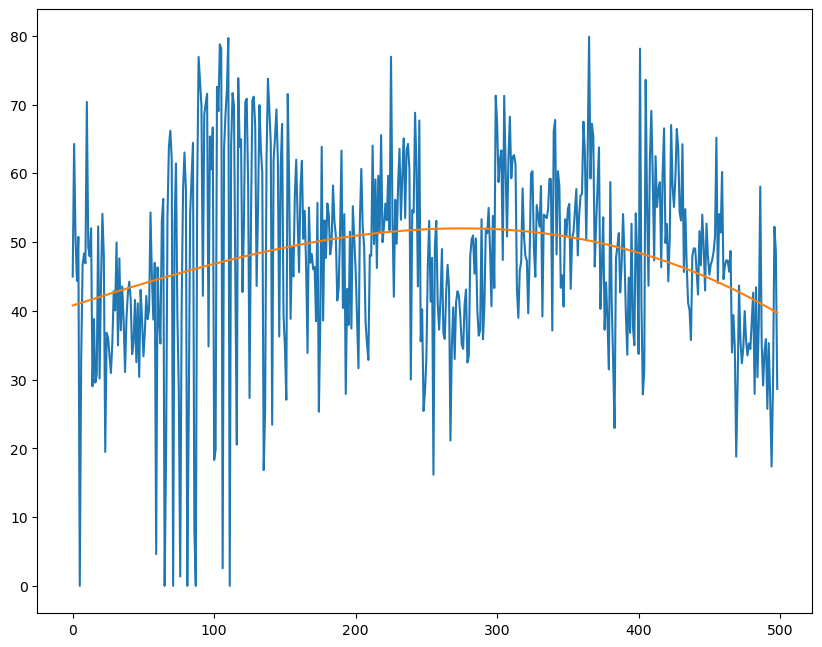

In [228]:

plt.plot(x, y)
plt.plot(x,p(x))
plt.show()

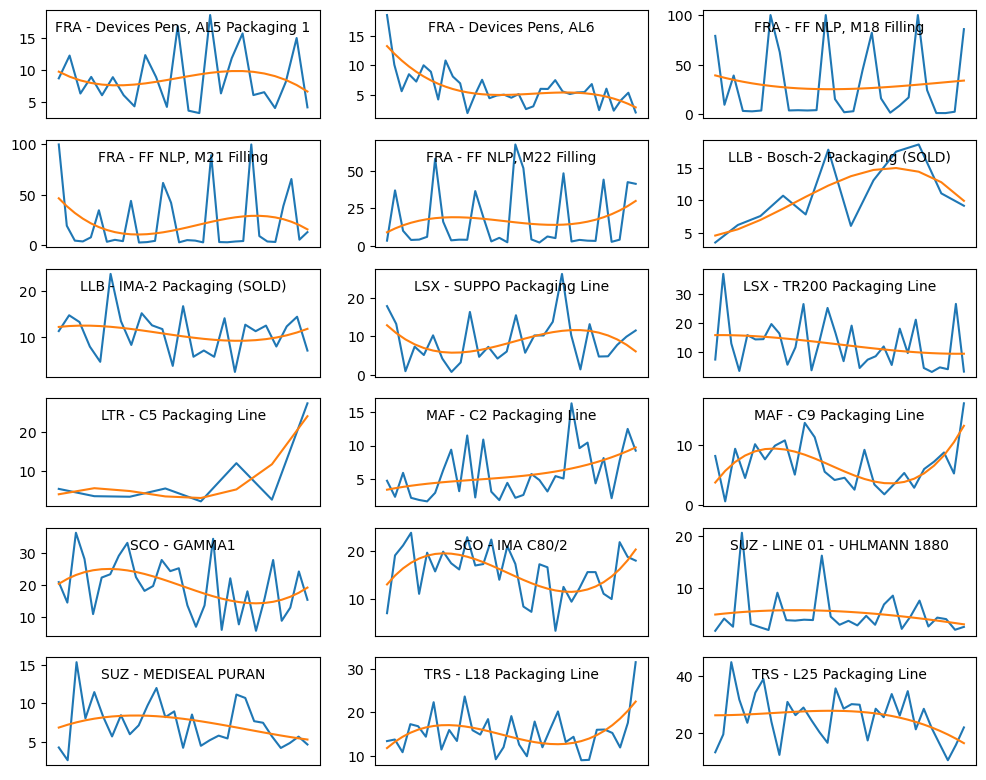

In [229]:
fig, axs = plt.subplots(int(len(df.Line.unique())/3),3, figsize=(12,10))

i=0
j=0
d = {}

for line in df.Line.unique():
    y = df[df.Line == line]['Changeover'].dropna()
    x = np.arange(len(y))
    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)

    axs[i,j].plot(x, y)
    axs[i,j].plot(x,p(x))
    # axs[i,j].set_title(line, x=0.9, y=0.9)
    axs[i,j].axes.get_xaxis().set_visible(False)
    axs[i,j].text(0.5, 0.8, line, transform=axs[i,j].transAxes, ha="center")

    if j<2:
        j+=1
    else:
        i+=1
        j=0
   
    d[line]=round(p(x[-1])-p(x[0]),0)

plt.show()

In [230]:
dic2=dict(sorted(d.items(),key= lambda x:x[1]))
print ("Line, Point of OEE")
for key, value in dic2.items():
    print ("{} {}".format(key, value))

Line, Point of OEE
FRA - FF NLP, M21 Filling -31.0
FRA - Devices Pens, AL6 -10.0
TRS - L25 Packaging Line -10.0
LSX - SUPPO Packaging Line -7.0
LSX - TR200 Packaging Line -6.0
FRA - FF NLP, M18 Filling -5.0
FRA - Devices Pens, AL5 Packaging 1 -3.0
SUZ - LINE 01 - UHLMANN 1880 -2.0
SUZ - MEDISEAL PURAN -2.0
SCO - GAMMA1 -1.0
LLB - IMA-2 Packaging (SOLD) -0.0
LLB - Bosch-2 Packaging (SOLD) 5.0
MAF - C2 Packaging Line 6.0
SCO - IMA C80/2 7.0
MAF - C9 Packaging Line 10.0
TRS - L18 Packaging Line 11.0
LTR - C5 Packaging Line 20.0
FRA - FF NLP, M22 Filling 21.0


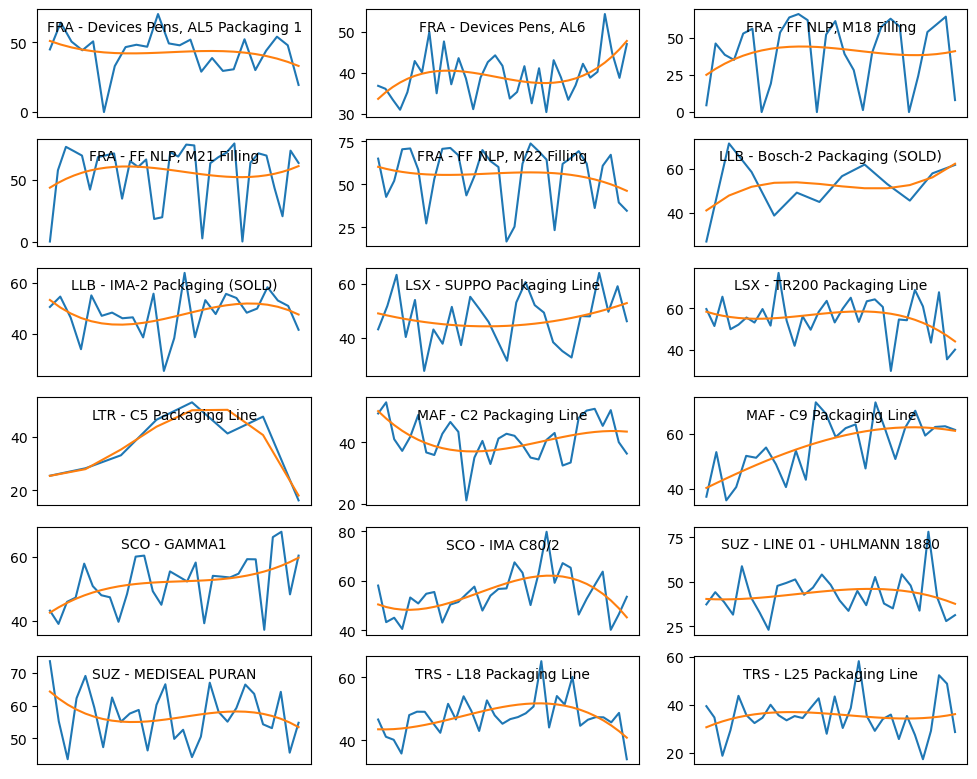

In [158]:
fig, axs = plt.subplots(int(len(df.Line.unique())/3),3, figsize=(12,10))

i=0
j=0
d = {}

for line in df.Line.unique():
    y = df[df.Line == line]['OEE %'].dropna()
    x = np.arange(len(y))
    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)

    axs[i,j].plot(x, y)
    axs[i,j].plot(x,p(x))
    # axs[i,j].set_title(line, x=0.9, y=0.9)
    axs[i,j].axes.get_xaxis().set_visible(False)
    axs[i,j].text(0.5, 0.8, line, transform=axs[i,j].transAxes, ha="center")

    if j<2:
        j+=1
    else:
        i+=1
        j=0
   
    d[line]=round(p(x[-1])-p(x[0]),0)

plt.show()

In [160]:
dic2=dict(sorted(d.items(),key= lambda x:x[1]))
print ("Line, Point of OEE")
for key, value in dic2.items():
    print ("{} {}".format(key, value))

Line, Point of OEE
FRA - Devices Pens, AL5 Packaging 1 -18.0
FRA - FF NLP, M22 Filling -14.0
LSX - TR200 Packaging Line -14.0
SUZ - MEDISEAL PURAN -11.0
LTR - C5 Packaging Line -7.0
MAF - C2 Packaging Line -7.0
LLB - IMA-2 Packaging (SOLD) -6.0
SCO - IMA C80/2 -5.0
SUZ - LINE 01 - UHLMANN 1880 -3.0
TRS - L18 Packaging Line -3.0
LSX - SUPPO Packaging Line 4.0
TRS - L25 Packaging Line 5.0
FRA - Devices Pens, AL6 14.0
FRA - FF NLP, M18 Filling 16.0
SCO - GAMMA1 17.0
FRA - FF NLP, M21 Filling 18.0
LLB - Bosch-2 Packaging (SOLD) 21.0
MAF - C9 Packaging Line 21.0


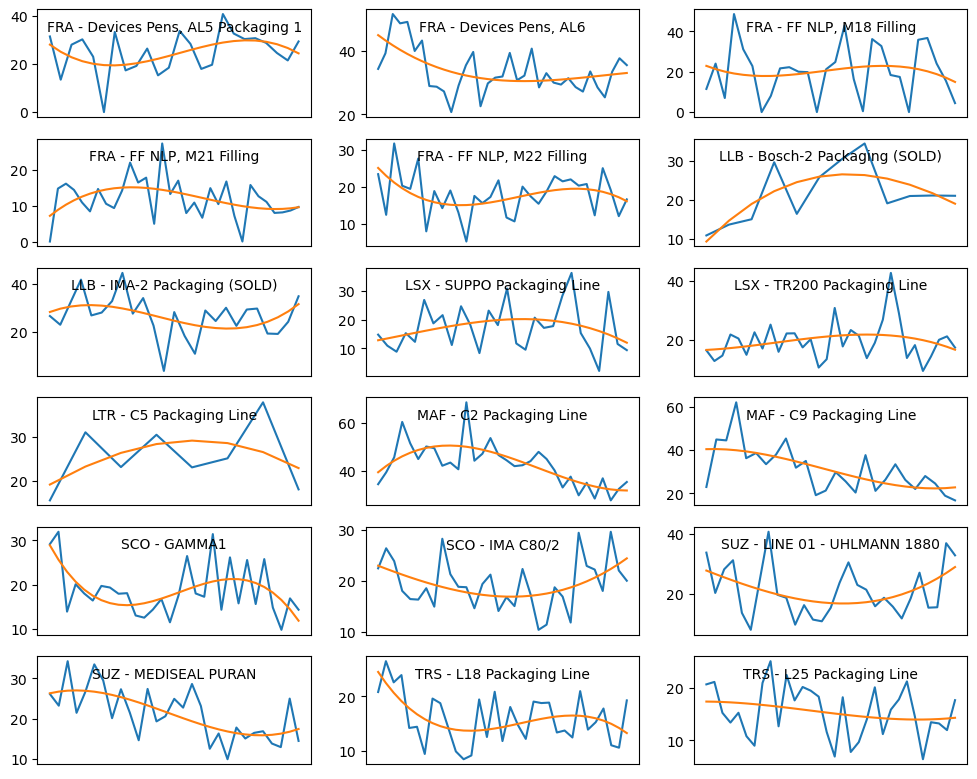

In [120]:
fig, axs = plt.subplots(int(len(df.Line.unique())/3),3, figsize=(12,10))

i=0
j=0
d = {}

for line in df.Line.unique():
    y = df[df.Line == line]['Unplanned_tech_loss'].dropna()
    x = np.arange(len(y))
    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)

    axs[i,j].plot(x, y)
    axs[i,j].plot(x,p(x))
    # axs[i,j].set_title(line, x=0.9, y=0.9)
    axs[i,j].axes.get_xaxis().set_visible(False)
    axs[i,j].text(0.5, 0.8, line, transform=axs[i,j].transAxes, ha="center")

    if j<2:
        j+=1
    else:
        i+=1
        j=0
   
    d[line]=round(p(x[-1])-p(x[0]),0)

plt.show()

In [192]:
best = min(d, key=d.get)
print(best, d[best])

MAF - C9 Packaging Line -17.635159162131036


In [136]:
sorted(d.items(),key= lambda x:x[1])

[('MAF - C9 Packaging Line', -18.0),
 ('SCO - GAMMA1', -17.0),
 ('FRA - Devices Pens, AL6', -12.0),
 ('TRS - L18 Packaging Line', -11.0),
 ('FRA - FF NLP, M22 Filling', -9.0),
 ('SUZ - MEDISEAL PURAN', -9.0),
 ('FRA - FF NLP, M18 Filling', -8.0),
 ('MAF - C2 Packaging Line', -8.0),
 ('FRA - Devices Pens, AL5 Packaging 1', -4.0),
 ('TRS - L25 Packaging Line', -3.0),
 ('LSX - SUPPO Packaging Line', -1.0),
 ('LSX - TR200 Packaging Line', 0.0),
 ('SCO - IMA C80/2', 1.0),
 ('SUZ - LINE 01 - UHLMANN 1880', 1.0),
 ('FRA - FF NLP, M21 Filling', 2.0),
 ('LLB - IMA-2 Packaging (SOLD)', 3.0),
 ('LTR - C5 Packaging Line', 4.0),
 ('LLB - Bosch-2 Packaging (SOLD)', 10.0)]

In [156]:
dic2=dict(sorted(d.items(),key= lambda x:x[1]))
print ("Line, Point of OEE")
for key, value in dic2.items():
    print ("{} {}".format(key, value))

Line, Point of OEE
FRA - Devices Pens, AL5 Packaging 1 -18.0
FRA - FF NLP, M22 Filling -14.0
LSX - TR200 Packaging Line -14.0
SUZ - MEDISEAL PURAN -11.0
LTR - C5 Packaging Line -7.0
MAF - C2 Packaging Line -7.0
LLB - IMA-2 Packaging (SOLD) -6.0
SCO - IMA C80/2 -5.0
SUZ - LINE 01 - UHLMANN 1880 -3.0
TRS - L18 Packaging Line -3.0
LSX - SUPPO Packaging Line 4.0
TRS - L25 Packaging Line 5.0
FRA - Devices Pens, AL6 14.0
FRA - FF NLP, M18 Filling 16.0
SCO - GAMMA1 17.0
FRA - FF NLP, M21 Filling 18.0
LLB - Bosch-2 Packaging (SOLD) 21.0
MAF - C9 Packaging Line 21.0


In [187]:
print ("variable of polyfit is " + p.variable)
print ("variables of x are: ")
print (p(x))

variable of polyfit is x
variables of x are: 
[17.37783967 17.35209938 17.30080693 17.22609385 17.13009164 17.01493181
 16.88274587 16.73566532 16.57582168 16.40534646 16.22637117 16.04102731
 15.85144639 15.65975992 15.46809942 15.27859639 15.09338233 14.91458877
 14.7443472  14.58478915 14.43804611 14.30624959 14.19153111 14.09602217
 14.02185429 13.97115897 13.94606772 13.94871205 13.98122347 14.04573349
 14.14437362 14.27927536]


In [186]:
p.c

array([ 3.55251522e-04, -1.38418285e-02, -1.22537181e-02,  1.73778397e+01])

In [200]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from IPython.core.debugger import set_trace

# Load Data
df = px.data.tips()
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("ScikitLearn: Polynomial features"),
    dcc.Graph(id='graph'),
    html.Label([
        "Set number of features",
        dcc.Slider(id='PolyFeat',
    min=1,
    max=6,
    marks={i: '{}'.format(i) for i in range(10)},
    value=1,
) 
    ]),
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("PolyFeat", "value")]
)

def update_figure(nFeatures):
    
    global model

    # data
    # df = px.data.tips()
    x=df.index
    y=df['Unplanned_tech_loss']

    # model
    model = make_pipeline(PolynomialFeatures(nFeatures), LinearRegression())
    model.fit(np.array(x).reshape(-1, 1), y)
    x_reg = x.values
    y_reg = model.predict(x_reg.reshape(-1, 1))
    df['Unplanned_tech_loss']=y_reg

    # figure setup and trace for observations
    fig = go.Figure()
    fig.add_traces(go.Scatter(x=df.index, y=df['Unplanned_tech_loss'], mode='markers', name = 'observations'))

    # trace for polynomial model
    # df=df.sort_values(by=[''])
    fig.add_traces(go.Scatter(x=df.index, y=df['Unlanned_tech_loss'], mode='lines', name = 'model'))
    
    # figure layout adjustments
    fig.update_layout(yaxis=dict(range=[0,12]))
    fig.update_layout(xaxis=dict(range=[0,60]))
    print(df['model'].tail())
    return(fig)

# Run app and display result inline in the notebook
app.enable_dev_tools(dev_tools_hot_reload =True)
app.run_server(mode='inline', port = 8070, dev_tools_ui=True, #debug=True,
              dev_tools_hot_reload =True, threaded=True)